In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

## Load data
Dataset contains 21,613 house sale records in 21 variables. From [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction)

In [2]:
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


## Prepare target variable and features

In [4]:
target = df[df["price"] <= 3000000]["price"]

In [5]:
features = pd.DataFrame()
features["sqft_living_log"] = df[df["price"] <= 3000000]["sqft_living"].apply(lambda x: np.log(x))
features["sqft_lot_log"] = df[df["price"] <= 3000000]["sqft_lot"].apply(lambda x: np.log(x))
features["bedrooms"] = df[df["price"] <= 3000000]["bedrooms"]
features["bathrooms"] = df[df["price"] <= 3000000]["bathrooms"]
features["waterfront"] = df[df["price"] <= 3000000]["waterfront"]
features["age_log"] = np.log((df[df["price"] <= 3000000]["date"].apply(lambda x: float(x[0:4]))) - (df[df["price"] <= 3000000]["yr_built"]) + 2)
features["condition_sqrt"] = df[df["price"] <= 3000000]["condition"].apply(lambda x: np.sqrt(x))

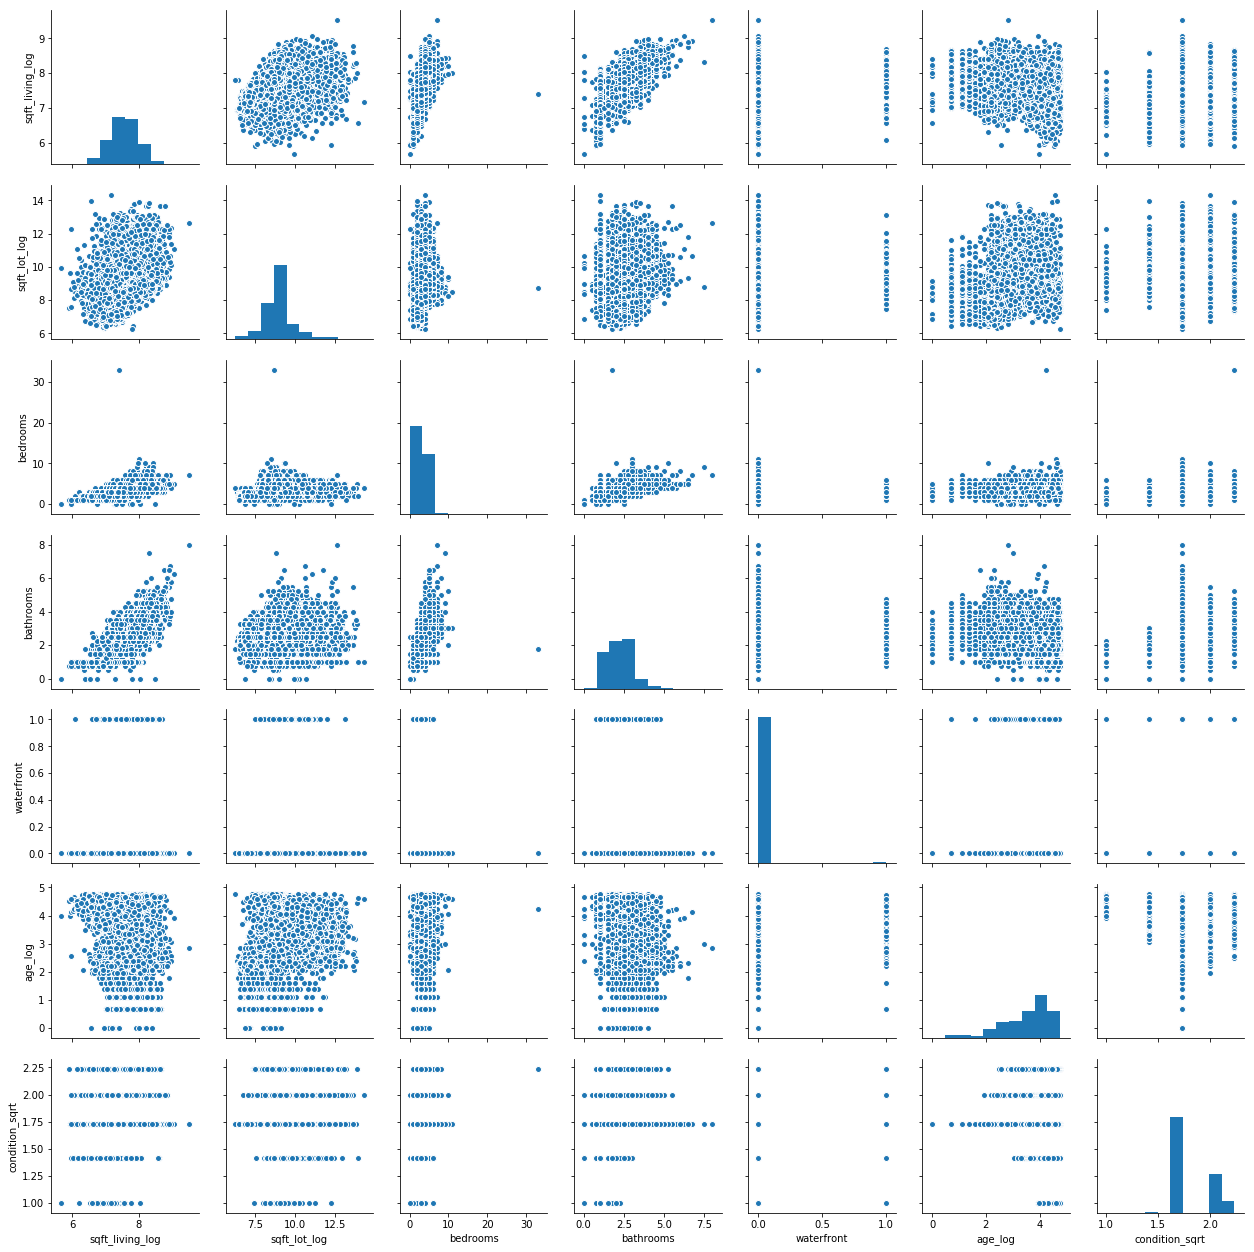

In [6]:
sns.pairplot(features)
plt.show()

## OLS regression

In [9]:
X = features
y = target

In [10]:
lm = LinearRegression()
lm.fit(X, y)

print("Intercept:\n", lm.intercept_)
print("Coefficients:\n", lm.coef_)
print("R^2:\n", lm.score(X, y))

Intercept:
 -3331114.2740422804
Coefficients:
 [499479.222662   -31477.46907957 -52452.56012118  90680.56948054
 636508.92781564  66887.62259523  67250.53060996]
R^2:
 0.46200776459055815


In [11]:
start_time = time.time()
score = cross_val_score(lm, X, y, cv=10)
print(score)
end_time = time.time()
print("\n--- {:.5f} seconds ---".format(end_time - start_time))

[0.46481619 0.46620293 0.45991696 0.42748881 0.43763921 0.48550469
 0.46586794 0.45751289 0.47779333 0.35375124]

--- 0.09275 seconds ---


Overfitting.

## KNN Regression

In [12]:
def cross_val_repeat_knn(X, y, cvs, upper_k_limit, weights_param="uniform"):
    results = {
        "k_num": [i for i in range(1, upper_k_limit + 1)],
        "mean_r_squared": [],
        "std_r_squared": []
    }
    
    for k in results["k_num"]:
        knn = KNeighborsRegressor(n_neighbors=k, weights=weights_param)
        knn.fit(X, y)
        score = cross_val_score(knn, X, y, cv=cvs)
        results["mean_r_squared"].append(np.mean(score))
        results["std_r_squared"].append(np.std(score))
    
    df = pd.DataFrame(results)
    df = df[["k_num", "mean_r_squared", "std_r_squared"]]
    return df

In [13]:
start_time = time.time()
knn_results = cross_val_repeat_knn(X, y, 10, 30)
print(knn_results)
end_time = time.time()
print("\n--- {:.5f} seconds ---".format(end_time - start_time))

    k_num  mean_r_squared  std_r_squared
0       1        0.224950       0.078215
1       2        0.411178       0.045520
2       3        0.474880       0.043601
3       4        0.503065       0.040700
4       5        0.515650       0.037999
5       6        0.523156       0.038466
6       7        0.529424       0.039503
7       8        0.534669       0.041497
8       9        0.536977       0.038947
9      10        0.539581       0.038618
10     11        0.542541       0.036917
11     12        0.544991       0.037068
12     13        0.546994       0.037674
13     14        0.545571       0.036943
14     15        0.546180       0.036630
15     16        0.545343       0.035250
16     17        0.545634       0.034989
17     18        0.545390       0.034235
18     19        0.544530       0.034006
19     20        0.544187       0.034858
20     21        0.544575       0.034256
21     22        0.544279       0.034287
22     23        0.543803       0.034002
23     24       

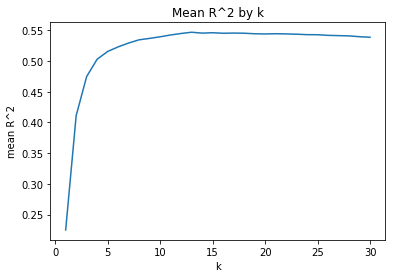

In [14]:
plt.plot(knn_results["k_num"], knn_results["mean_r_squared"])
plt.title("Mean R^2 by k")
plt.xlabel("k")
plt.ylabel("mean R^2")
plt.show()

Looks like things settle down between 10-15 neighbors.

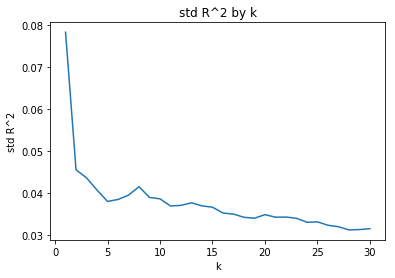

In [15]:
plt.plot(knn_results["k_num"], knn_results["std_r_squared"])
plt.title("std R^2 by k")
plt.xlabel("k")
plt.ylabel("std R^2")
plt.show()

Standard deviation is a bit spikier and doesn't appear to settle until between 23 and 30 neighbors.

## KNN with weights

In [16]:
start_time = time.time()
knn_results_with_weights = cross_val_repeat_knn(X, y, 10, 30, "distance")
print(knn_results_with_weights)
end_time = time.time()
print("\n--- {:.5f} seconds ---".format(end_time - start_time))

    k_num  mean_r_squared  std_r_squared
0       1        0.224950       0.078215
1       2        0.405258       0.047854
2       3        0.469009       0.045383
3       4        0.499360       0.042587
4       5        0.513753       0.039785
5       6        0.522894       0.039038
6       7        0.530080       0.039501
7       8        0.535717       0.040873
8       9        0.538902       0.038953
9      10        0.542256       0.038617
10     11        0.545358       0.037211
11     12        0.548015       0.037314
12     13        0.550114       0.037616
13     14        0.549520       0.037055
14     15        0.550354       0.036800
15     16        0.550100       0.035722
16     17        0.550598       0.035406
17     18        0.550733       0.034749
18     19        0.550310       0.034582
19     20        0.550244       0.035166
20     21        0.550714       0.034639
21     22        0.550570       0.034704
22     23        0.550280       0.034321
23     24       

## Adding normalization

In [17]:
from sklearn import preprocessing
features_z = preprocessing.scale(X)

In [18]:
start_time = time.time()
knn_results_normal = cross_val_repeat_knn(features_z, y, 10, 30, "distance")
print(knn_results_normal)
end_time = time.time()
print("\n--- {:.5f} seconds ---".format(end_time - start_time))

    k_num  mean_r_squared  std_r_squared
0       1        0.246925       0.035783
1       2        0.417812       0.028516
2       3        0.480343       0.026989
3       4        0.511204       0.029261
4       5        0.529135       0.028743
5       6        0.543351       0.026022
6       7        0.549148       0.025362
7       8        0.554751       0.022723
8       9        0.559130       0.022880
9      10        0.563972       0.021240
10     11        0.565628       0.020750
11     12        0.568519       0.020364
12     13        0.570316       0.020730
13     14        0.572642       0.020410
14     15        0.573798       0.020096
15     16        0.575771       0.019737
16     17        0.576470       0.020004
17     18        0.576706       0.019788
18     19        0.577228       0.019643
19     20        0.577782       0.019439
20     21        0.578041       0.018977
21     22        0.578170       0.018521
22     23        0.578408       0.018682
23     24       

In [19]:
# Try higher k's
start_time = time.time()
knn_results_normal = cross_val_repeat_knn(features_z, y, 10, 60, "distance")
print(knn_results_normal)
end_time = time.time()
print("\n--- {:.5f} seconds ---".format(end_time - start_time))

    k_num  mean_r_squared  std_r_squared
0       1        0.246925       0.035783
1       2        0.417812       0.028516
2       3        0.480343       0.026989
3       4        0.511204       0.029261
4       5        0.529135       0.028743
5       6        0.543351       0.026022
6       7        0.549148       0.025362
7       8        0.554751       0.022723
8       9        0.559130       0.022880
9      10        0.563972       0.021240
10     11        0.565628       0.020750
11     12        0.568519       0.020364
12     13        0.570316       0.020730
13     14        0.572642       0.020410
14     15        0.573798       0.020096
15     16        0.575771       0.019737
16     17        0.576470       0.020004
17     18        0.576706       0.019788
18     19        0.577228       0.019643
19     20        0.577782       0.019439
20     21        0.578041       0.018977
21     22        0.578170       0.018521
22     23        0.578408       0.018682
23     24       

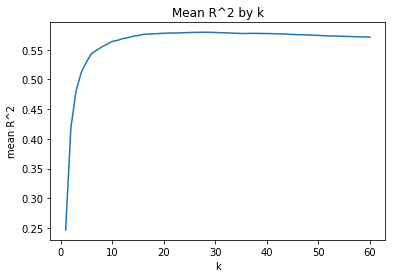

In [20]:
plt.plot(knn_results_normal["k_num"], knn_results_normal["mean_r_squared"])
plt.title("Mean R^2 by k")
plt.xlabel("k")
plt.ylabel("mean R^2")
plt.show()

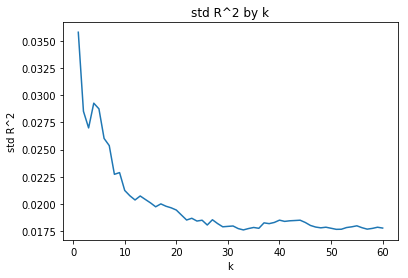

In [21]:
plt.plot(knn_results_normal["k_num"], knn_results_normal["std_r_squared"])
plt.title("std R^2 by k")
plt.xlabel("k")
plt.ylabel("std R^2")
plt.show()

In [28]:
# Take best K
# k = 40 ?
# Test/Train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_z, y)

start_time = time.time()

knn = KNeighborsRegressor(n_neighbors=40, weights="distance")
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

end_time = time.time()
print("\n--- {:.5f} seconds ---".format(end_time - start_time))

0.5809311041882441

--- 0.61088 seconds ---


In [29]:
# Track runtime and compare to OLS

# The model outperforms OLS on R^2, but is slower.

## Summary
The OLS regression model explains about 50% of the variance in the data but is potentially overfit. The KNN regression model explains about 54% of the variance in the data (with k >= 12), which is indeed higher than the OLS model, but not much. I would say that these models are similar. That being said, I actually expected the OLS model to outperform the KNN model due to the presence of categorical data in the dataset.

Overall, I  still prefer the OLS model due to that model's ability to explain the individual impact of the variables through the coefficient estimates, which I think is interesting information for further study and understanding. That being said, if all I was interested in was getting the best prediction, then the KNN model would have to be preferred due to the better R-squared score.